In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
# plt.style.use('fivethirtyeight')
plt.rc('font', family='Times New Roman')

In [ ]:
labels = ['(0, 0)', '(1, 1)', '(1, 3)', '(1, 5)', '(1, 7)', '(1, 9)', 
          '(2, 1)', '(2, 3)', '(2, 5)', '(2, 7)', '(2, 9)',
          '(3, 1)', '(3, 3)', '(3, 5)', '(3, 7)', '(3, 9)']
datas = [(48.96, 36.02, 56.70), 
         (50.14, 37.19, 55.16), (47.59, 36.60, 57.08), (49.40, 38.24, 59.02), (49.35, 37.20, 59.14), (49.97, 38.43, 57.32),
         (47.59, 37.94, 55.40), (47.47, 36.08, 56.13), (49.79, 38.37, 57.78), (49.43, 37.43, 59.06), (48.94, 37.54, 56.44),
         (49.27, 37.97, 58.08), (49.91, 38.18, 58.77), (46.88, 39.25, 59.57), (48.60, 39.03, 60.46), (49.20, 38.40, 58.29)]

In [ ]:
fs, xs, ys = [], [], []
for item_ in datas:
    fs.append(item_[0])
    xs.append(item_[1])
    ys.append(item_[2])
BASE_SIZE = 48.96
norm_size = 50 + (np.array(fs) - BASE_SIZE) * 20
print(norm_size)

plt.figure(dpi=200)
plt.scatter(xs[0], ys[0], norm_size[0], alpha=0.9, c='green')
plt.scatter(xs[1:], ys[1:], norm_size[1:], alpha=0.9)
plt.scatter(xs[-2], ys[-2], norm_size[-2], alpha=0.9, c='red')

plt.xlim(35.9, 39.6)
plt.ylim(54.5, 61)

plt.xlabel('PSDS1 (%)', fontdict={'family':'Times New Roman', 'fontsize':15})
plt.ylabel('PSDS2 (%)', fontdict={'family':'Times New Roman', 'fontsize':15})


for i, label in enumerate(labels):
    text = plt.text(xs[i], ys[i], label, fontsize=10, va='top')
    if i == 0:
        text.set_color('green')
    if i == 14:
        text.set_color('red')
plt.text(36.0, 60.7, '(@Layers, @Numbers)', 
         bbox={'facecolor': '#74C476', 
              'edgecolor':'b',
               'alpha': 0.5,
               'pad': 2,
              }
        )
plt.show()

In [2]:
import argparse
import logging
import math
import os
import pickle
import random
import sys
from pathlib import Path
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import pandas as pd
import torch
import yaml
from torch.utils.data import DataLoader

from baseline_utils.ManyHotEncoder import ManyHotEncoder
from dataset import SEDDataset
from visualizer import get_local
get_local.activate() # 激活装饰器
from models.pro_teacher import SEDModel 
from post_processing import PostProcess
from trainer import MeanTeacherTrainerOptions
from transforms import get_transforms

In [3]:
def seed_everything(seed):
    logging.info("random seed = %d" % seed)
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
parser = argparse.ArgumentParser()
parser.add_argument("--exp_name", default="20_proteacher", type=str, help="exp name used for the training")
parser.add_argument("--test_meta", default="/data0/gaolj/sed_data/DCASE2020/metadata/eval/public.tsv")
parser.add_argument("--test_audio_dir", default="/data0/gaolj/sed_data/DCASE2020/audio/eval/public/")
args = parser.parse_known_args()[0]

In [5]:
exp_name = Path(f"/home/gaolj/ProTeacher/exp/{args.exp_name}")
assert exp_name.exists()
# load config
with open(exp_name / "config.yaml") as f:
    cfg = yaml.safe_load(f)
test_df = pd.read_csv(args.test_meta, header=0, sep="\t")
seed_everything(cfg["seed"])

n_frames = math.ceil(
    cfg["max_len_seconds"] * cfg["feature"]["sample_rate"] / cfg["feature"]["mel_spec"]["hop_size"]
)
# Note: assume that the same class used in the training is included at least once.
classes = test_df.event_label.dropna().sort_values().unique()
many_hot_encoder = ManyHotEncoder(labels=classes, n_frames=n_frames)
encode_function = many_hot_encoder.encode_strong_df
test_df.onset = test_df.onset * cfg["feature"]["sample_rate"] // cfg["feature"]["mel_spec"]["hop_size"]
test_df.offset = test_df.offset * cfg["feature"]["sample_rate"] // cfg["feature"]["mel_spec"]["hop_size"]

feat_dir = Path(
    f"{cfg['feature']['feat_root']}/sr{cfg['feature']['sample_rate']}_n_mels{cfg['feature']['mel_spec']['n_mels']}_"
    + f"n_fft{cfg['feature']['mel_spec']['n_fft']}_hop_size{cfg['feature']['mel_spec']['hop_size']}"
)
stats = np.load(
    f"/home/gaolj/ProTeacher/exp/{cfg['exp_name']}/stats.npz",
)

norm_dict_params = {
    "mean": stats["mean"],
    "std": stats["std"],
    "mode": cfg["norm_mode"],
}

test_transforms = get_transforms(
    cfg["data_aug"],
    nb_frames=n_frames,
    norm_dict_params=norm_dict_params,
    training=False,
    prob=0.0,
)

test_dataset = SEDDataset(
    test_df,
    data_dir=feat_dir / "eval/public/",
    encode_function=encode_function,
    pooling_time_ratio=cfg["pooling_time_ratio"],
    transforms=test_transforms,
)

if cfg["ngpu"] > 1:
    cfg["batch_size"] *= cfg["ngpu"]

test_loader = DataLoader(
    test_dataset,
    batch_size=cfg["batch_size"],
    shuffle=False,
    num_workers=cfg["num_workers"],
    pin_memory=True,
)


seed_everything(cfg["seed"])

model = SEDModel(n_class=len(classes), cnn_kwargs=cfg["model"]["cnn"],
                    encoder_kwargs=cfg["model"]["encoder"],
                    )
#%%
checkpoint = torch.load(exp_name / "model" / "model_best_score.pth")
model.load_state_dict(checkpoint["state_dict"])
trainer_options = MeanTeacherTrainerOptions(**cfg["trainer_options"])
trainer_options._set_validation_options(
    valid_meta=args.test_meta,
    valid_audio_dir=args.test_audio_dir,
    max_len_seconds=cfg["max_len_seconds"],
    sample_rate=cfg["feature"]["sample_rate"],
    hop_size=cfg["feature"]["mel_spec"]["hop_size"],
    pooling_time_ratio=cfg["pooling_time_ratio"],
)
output_dir = exp_name / "test"
output_dir.mkdir(exist_ok=True)
with open(exp_name / "post_process_params.pickle", "rb") as f:
    pp_params = pickle.load(f)

model = model.to(trainer_options.device)

INFO:root:random seed = 1
INFO:root:random seed = 1


In [45]:
model.eval()
with torch.no_grad():
    (batch_input, batch_target, data_ids) = test_dataset.__getitem__(0)
    predicts = model(batch_input.unsqueeze(0).cuda(), prompt_tuning=True)
    att_map = get_local.cache
    att_map = att_map['RelMultiHeadAttn.forward']
    

In [56]:
len(att_map)

21

In [54]:
att = att_map[7].squeeze()
att.shape

(70, 70, 4)

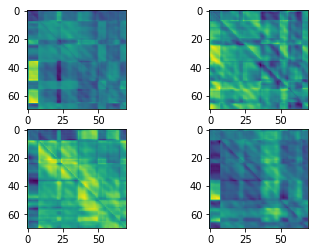

In [55]:
plt.subplot(221)
plt.imshow(att[:, :, 0])
plt.subplot(222)
plt.imshow(att[:, :, 1])
plt.subplot(223)
plt.imshow(att[:, :, 2])
plt.subplot(224)
plt.imshow(att[:, :, 3])

In [ ]:
plt.imshow(torch.sigmoid(predicts["strong"]).cpu().data.numpy().T)

In [ ]:
predicts["strong"] = torch.sigmoid(predicts["strong"]).cpu().data.numpy()
predicts["weak"] = torch.sigmoid(predicts["weak"]).cpu().data.numpy()

In [ ]:
plt.imshow(predicts["strong"][0])

<AxesSubplot:ylabel='Density'>

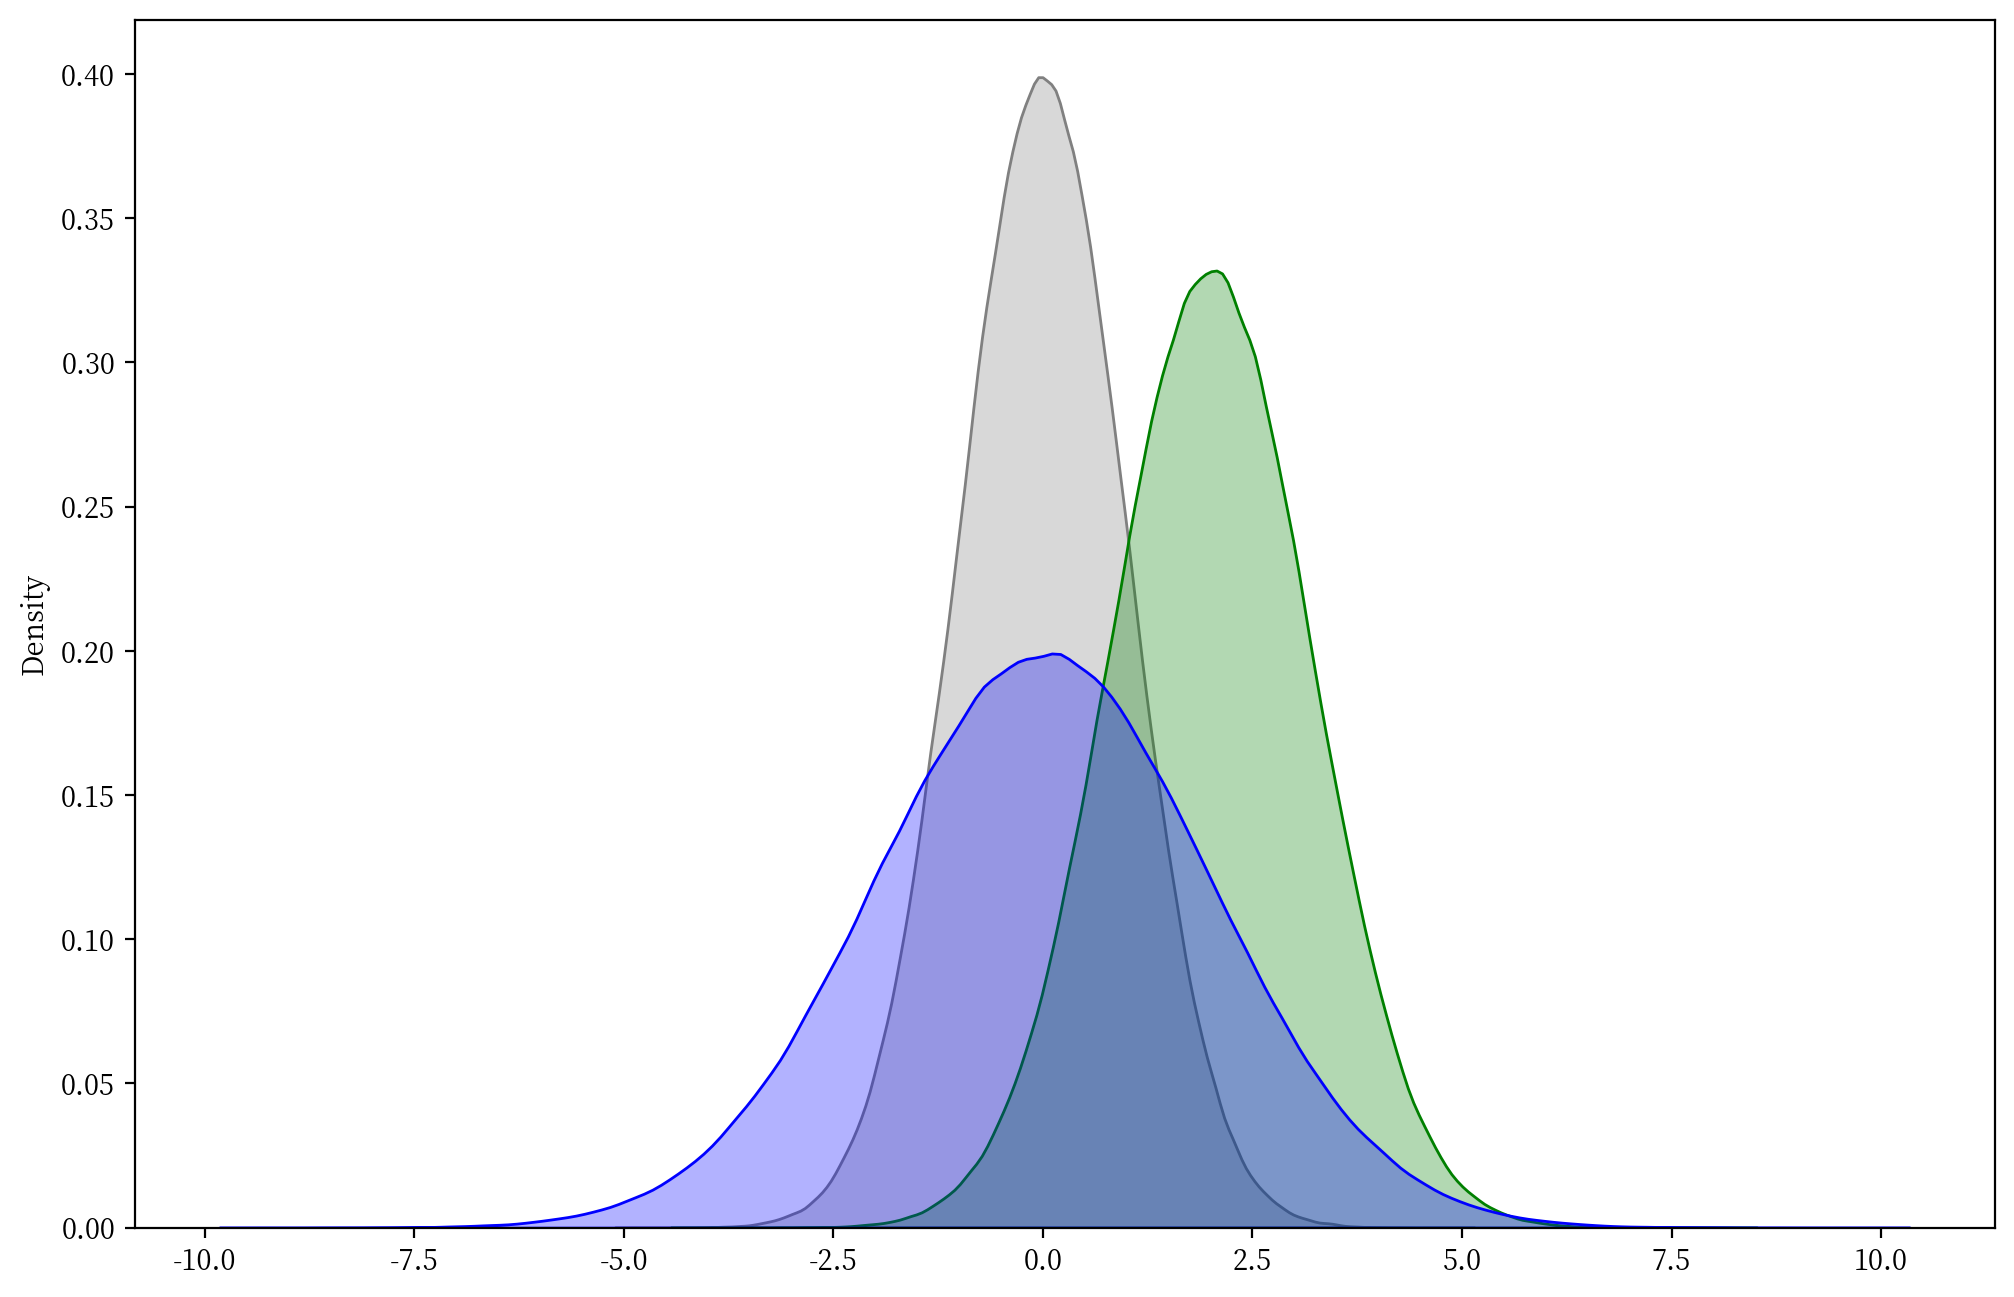

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import math
from mplfonts import use_font
import seaborn as sb
use_font('Noto Serif CJK SC')#指定中文字体

def normal_distribution(x, mean, sigma):
    return np.exp(-1*((x-mean)**2)/(2*(sigma**2)))/(math.sqrt(2*np.pi) * sigma)
 

mean1, sigma1 = 0, 1
x1 = np.linspace(mean1 - 6*sigma1, mean1 + 6*sigma1, 100)
 
mean2, sigma2 = 0, 2
x2 = np.linspace(mean2 - 6*sigma2, mean2 + 6*sigma2, 100)
 
mean3, sigma3 = 5, 1
x3 = np.linspace(mean3 - 6*sigma3, mean3 + 6*sigma3, 100)
 
y1 = normal_distribution(x1, mean1, sigma1)
y2 = normal_distribution(x2, mean2, sigma2)
y3 = normal_distribution(x3, mean3, sigma3)
plt.figure(figsize=(12, 8), dpi=200)
import numpy as np
import seaborn as sns

# Data simulation
rng = np.random.RandomState(4)
x1 = rng.normal(0, 1, size = 1000000)
x2 = rng.normal(2, 1.2, size = 1000000)
x3 = rng.normal(0, 2.0, size = 1000000)

# KDE plot
# plt.plot(y1)
sns.kdeplot(x = x1, color = "gray", alpha = 0.3, fill=True)
sns.kdeplot(x = x2, color = "green", alpha = 0.3, fill=True)
sns.kdeplot(x = x3, color = "blue", alpha = 0.3, fill=True)
